# Action Designator
This example will show the different kinds of Action Designators that are available. We will see how to create Action Designators and what they do.


Action Designators are high-level descriptions of actions which the robot should execute. 

Action Designators are created from an Action Designator Description, which describes the type of action as well as the parameter for this action. Parameter are given as a list of possible parameters.
For example, if you want to describe the robot moving to a table you would need a ```NavigateAction``` and a list of poses that are near the table. The Action Designator Description will then pick one of the poses and return a performable Action Designator which contains the picked pose. 



## Navigate Action
We will start with a simple example of the ```NavigateAction```. 

First, we need a BulletWorld with a robot.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import rospy

In [2]:
from pycram.worlds.bullet_world import BulletWorld, Object
from pycram.datastructures.pose import Pose
from pycram.datastructures.enums import ObjectType, WorldMode

world = BulletWorld(mode = WorldMode.GUI)

Unknown attribute "type" in /robot[@name='pr2']/link[@name='base_laser_link']
Unknown attribute "type" in /robot[@name='pr2']/link[@name='wide_stereo_optical_frame']
Unknown attribute "type" in /robot[@name='pr2']/link[@name='narrow_stereo_optical_frame']
Unknown attribute "type" in /robot[@name='pr2']/link[@name='laser_tilt_link']
Failed to import Giskard messages, the real robot will not be available
Could not import RoboKudo messages, RoboKudo interface could not be initialized
pybullet build time: Nov 28 2023 23:51:11


In [13]:
world.exit()

To move the robot we need to create a description and resolve it to an actual Designator. The description of navigation only needs a list of possible poses.

In [5]:
pr2 = Object("pr2", ObjectType.ROBOT, "pr2.urdf")

In [3]:
world.reset_world()

In [3]:
objs = world.objects

In [4]:
len(objs)

1

In [6]:
from pycram.designators.action_designator import NavigateAction
from pycram.datastructures.pose import Pose

pose = Pose([1, 0, 0], [0, 0, 0, 1])

# This is the Designator Description
navigate_description = NavigateAction(target_locations=[pose])

# This is the performable Designator
navigate_designator = navigate_description.resolve()

[INFO] [1725531488.758397]: Ontology [http://www.ease-crc.org/ont/SOMA-HOME.owl#]'s name: SOMA-HOME has been loaded
[INFO] [1725531488.759076]: - main namespace: SOMA-HOME
[INFO] [1725531488.759705]: - loaded ontologies:
[INFO] [1725531488.760115]: http://www.ease-crc.org/ont/SOMA-HOME.owl#
[INFO] [1725531488.760468]: http://www.ease-crc.org/ont/DUL.owl#
[INFO] [1725531488.760830]: http://www.ease-crc.org/ont/SOMA.owl#


What we now did was: create the pose where we want to move the robot, create a description describing a navigation with a list of possible poses (in this case the list contains only one pose) and create an action designator from the description. The action designator contains the pose picked from the list of possible poses and can be performed.

In [7]:
from pycram.process_module import simulated_robot

with simulated_robot:
    navigate_designator.perform()

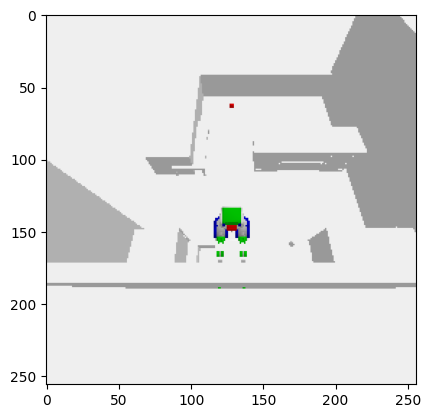

In [11]:
img_arr = world.get_images_for_target(kitchen.pose, Pose([2, 0, 4], [0, 0, 0, 1]))
image = np.array(img_arr[0])

plt.subplot(111)
plt.imshow(image)

In [12]:
print(img_arr[0].shape,img_arr[1].shape,img_arr[2].shape)

(256, 256, 4) (256, 256) (256, 256)


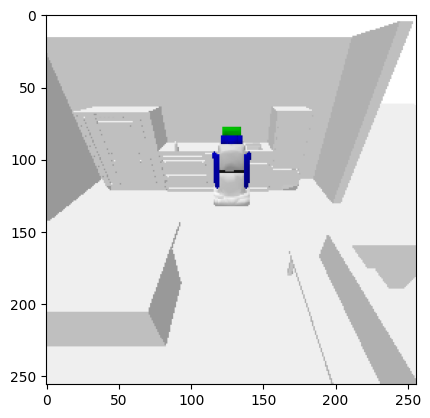

In [13]:
pr2_img_arr = world.get_images_for_target(pr2.pose, Pose([-2, 0, 2], [0, 0, 0, 1]))
image = np.array(pr2_img_arr[0])

plt.subplot(111)
plt.imshow(image)

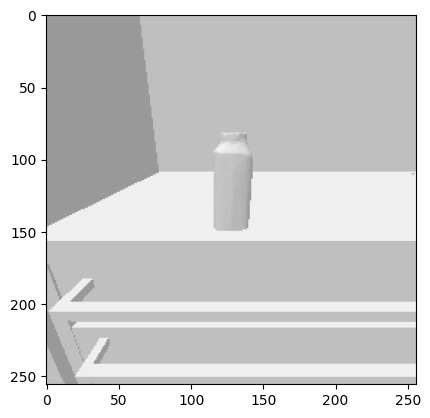

In [14]:
milk_img_arr = world.get_images_for_target(milk.pose, Pose([1, 1, 1], [0, 0, 0, 1]))
image = np.array(milk_img_arr[0])

plt.subplot(111)
plt.imshow(image)

Every designator that is performed needs to be in an environment that specifies where to perform the designator either on the real robot or the simulated one. This environment is called ```simulated_robot``` similar there is also a ```real_robot``` environment. 

There are also decorators which do the same thing but for whole methods, they are called ```with_real_robot``` and ```with_simulated_robot```.

## Move Torso
This action designator moves the torso up or down, specifically it sets the torso joint to a given value.

We start again by creating a description and resolving it to a designator. Afterwards, the designator is performed in a ```simulated_robot``` environment. 

In [15]:
from pycram.designators.action_designator import MoveTorsoAction
from pycram.process_module import simulated_robot

torso_pose = 0.2

torso_desig = MoveTorsoAction([torso_pose]).resolve()

with simulated_robot:
    torso_desig.perform()

## Set Gripper
As the name implies, this action designator is used to open or close the gripper. 

The procedure is similar to the last time, but this time we will shorten it a bit.

In [16]:
from pycram.designators.action_designator import SetGripperAction
from pycram.process_module import simulated_robot

gripper = "right"
motion = "close"

with simulated_robot:
    SetGripperAction(grippers=[gripper], motions=[motion]).resolve().perform()

## Park Arms
Park arms is used to move one or both arms into the default parking position.

In [17]:
from pycram.designators.action_designator import ParkArmsAction
from pycram.process_module import simulated_robot
from pycram.datastructures.enums import Arms

with simulated_robot:
    ParkArmsAction([Arms.BOTH]).resolve().perform()

## Pick Up and Place
Since these two are dependent on each other, meaning you can only place something when you picked it up beforehand, they will be shown together. 

These action designators use object designators, which will not be further explained in this tutorial so please check the example on object designators for more details. 

To start we need an environment in which we can pick up and place things as well as an object to pick up.

In [4]:
kitchen = Object("kitchen", ObjectType.ENVIRONMENT, "kitchen.urdf")
milk = Object("milk", ObjectType.MILK, "milk.stl", pose=Pose([1.3, 1, 0.9]))

# world.reset_bullet_world()

Scalar element defined multiple times: limit
Unknown tag "rgba_color" in /robot[@name='milk_object']/link[@name='milk_main']/visual[1]/material[@name='white']
Scalar element defined multiple times: limit


In [9]:
from pycram.designators.action_designator import PickUpAction, PlaceAction, ParkArmsAction, MoveTorsoAction, NavigateAction
from pycram.designators.object_designator import BelieveObject
from pycram.process_module import simulated_robot
from pycram.datastructures.enums import Arms
from pycram.datastructures.pose import Pose

milk_desig = BelieveObject(names=["milk"])
arm ="right"

with simulated_robot:
    ParkArmsAction([Arms.BOTH]).resolve().perform()
    
    MoveTorsoAction([0.3]).resolve().perform()
    
    NavigateAction([Pose([0.72, 0.98, 0.0], 
                     [0.0, 0.0, 0.014701099828940344, 0.9998919329926708])]).resolve().perform()
    
    PickUpAction(object_designator_description=milk_desig, 
                     arms=[arm], 
                     grasps=["right"]).resolve().perform()
    
    NavigateAction([Pose([-1.90, 0.78, 0.0], 
                     [0.0, 0.0, 0.16439898301071468, 0.9863939245479175])]).resolve().perform()
    
    PlaceAction(object_designator_description=milk_desig, 
                target_locations=[Pose([-1.20, 1.0192, 0.9624], 
                                   [0.0, 0.0, 0.6339889056055381, 0.7733421413379024])], 
                arms=[arm]).resolve().perform()

[INFO] [1721735202.696523]: Waiting for IK service: /pr2_right_arm_kinematics/get_ik


IKError: Position header: 
  seq: 0
  stamp: 
    secs: 1721735206
    nsecs: 468132972
  frame_id: "pr2/torso_lift_link"
pose: 
  position: 
    x: 0.94525538531413
    y: -0.09139406472999498
    z: -0.12827496534148275
  orientation: 
    x: 1.2941012490165574e-08
    y: 7.020476696864241e-09
    z: 0.9653939873341008
    w: 0.2607957998495491 in frame 'torso_lift_link' is not reachable for end effector

In [17]:
world.reset_world()

## Look At
Look at lets the robot look at a specific point, for example if it should look at an object for detecting. 

In [11]:
from pycram.designators.action_designator import LookAtAction
from pycram.process_module import simulated_robot
from pycram.datastructures.pose import Pose

target_location = Pose([1, 0, 0.5], [0, 0, 0, 1])
with simulated_robot:
    LookAtAction(targets=[target_location]).resolve().perform()

## Detect
Detect is used to detect objects in the field of vision (FOV) of the robot. We will use the milk used in the pick up/place example, if you didn't execute that example you can spawn the milk with the following cell. The detect designator will return a resolved instance of an ObjectDesignatorDescription. 

In [12]:
milk = Object("milk", ObjectType.MILK, "milk.stl", pose=Pose([1.3, 1, 0.9]))

[ERROR] [1721735245.921285]: An object with the name milk already exists in the world.


In [13]:
from pycram.designators.action_designator import DetectAction, LookAtAction, ParkArmsAction, NavigateAction
from pycram.designators.object_designator import BelieveObject
from pycram.datastructures.enums import Arms
from pycram.process_module import simulated_robot
from pycram.datastructures.pose import Pose

milk_desig = BelieveObject(names=["milk"])

with simulated_robot:
    ParkArmsAction([Arms.BOTH]).resolve().perform()
    
    NavigateAction([Pose([0, 1, 0], [0, 0, 0, 1])]).resolve().perform()
    
    LookAtAction(targets=[milk_desig.resolve().pose]).resolve().perform()
    
    obj_desig = DetectAction(milk_desig).resolve().perform()
    
    print(obj_desig)

ObjectDesignatorDescription.Object(name=milk, obj_type=ObjectType.MILK, world_object=Object(_saved_states={}, 
id=4, 
world=<pycram.worlds.bullet_world.BulletWorld object at 0x7fe14ec536d0>, 
name=milk, 
obj_type=ObjectType.MILK, 
color=Color(R=1, G=1, B=1, A=1), 
description: ..., 
cache_manager=<pycram.cache_manager.CacheManager object at 0x7fe14ec53bb0>, 
local_transformer=<pycram.local_transformer.LocalTransformer object at 0x7fe14e3ef790>, 
original_pose=header: 
  seq: 0
  stamp: 
    secs: 1721735166
    nsecs: 971598863
  frame_id: "map"
pose: 
  position: 
    x: 1.3
    y: 1.0
    z: 0.9
  orientation: 
    x: 0.0
    y: 0.0
    z: 0.0
    w: 1.0, 
_current_pose=header: 
  seq: 0
  stamp: 
    secs: 1721735232
    nsecs: 933853864
  frame_id: "map"
pose: 
  position: 
    x: 1.3
    y: 1.0
    z: 0.9
  orientation: 
    x: 0.0
    y: 0.0
    z: 0.0
    w: 1.0, 
path=/home/malineni/ROS_WS/tpycram_ws/src/pycram/src/pycram/datastructures/../../../resources/cached/milk.urdf, 
tf_

## Transporting
Transporting can transport an object from its current position to another target position. It is similar to the Pick and Place plan used in the Pick-up and Place example. Since we need an Object which we can transport we spawn a milk, you don't need to do this if you already have spawned it in a previous example.

In [14]:
kitchen = Object("kitchen", ObjectType.ENVIRONMENT, "kitchen.urdf")
milk = Object("milk", ObjectType.MILK, "milk.stl", pose=Pose([1.3, 1, 0.9]))

[ERROR] [1720007679.269804]: An object with the name kitchen already exists in the world.
[ERROR] [1720007679.270801]: An object with the name milk already exists in the world.


In [14]:
from pycram.designators.action_designator import *
from pycram.designators.object_designator import *
from pycram.process_module import simulated_robot
from pycram.datastructures.pose import Pose

milk_desig = BelieveObject(names=["milk"])

with simulated_robot:
    MoveTorsoAction([0.3]).resolve().perform()
    TransportAction(milk_desig, ["left"], [Pose([-0.9, 0.9, 0.95], [0, 0, 1, 0])]).resolve().perform()

## Opening
Opening allows the robot to open a drawer, the drawer is identified by an ObjectPart designator which describes the handle of the drawer that should be grasped. 

For the moment this designator works only in the apartment environment, therefore we remove the kitchen and spawn the apartment.

In [15]:
kitchen.remove()

In [16]:
apartment = Object("apartment", ObjectType.ENVIRONMENT, "apartment.urdf")

Unknown tag "material" in /robot[@name='apartment']/link[@name='coffe_machine']/collision[1]


In [18]:
from pycram.designators.action_designator import *
from pycram.designators.object_designator import *
from pycram.datastructures.enums import Arms
from pycram.process_module import simulated_robot
from pycram.datastructures.pose import Pose

apartment_desig = BelieveObject(names=["apartment"]).resolve()
handle_deisg = ObjectPart(names=["handle_cab10_t"], part_of=apartment_desig)

with simulated_robot:
    MoveTorsoAction([0.25]).resolve().perform()
    ParkArmsAction([Arms.BOTH]).resolve().perform()
    NavigateAction([Pose([1.7474915981292725, 2.6873629093170166, 0.0],
                         [-0.0, 0.0, 0.5253598267689507, -0.850880163370435])]).resolve().perform()
    OpenAction(handle_deisg, ["right"]).resolve().perform()

## Closing
Closing lets the robot close an open drawer, like opening the drawer is identified by an ObjectPart designator describing the handle to be grasped. 

This action designator only works in the apartment environment for the moment, therefore we remove the kitchen and spawn the apartment. Additionally, we open the drawer such that we can close it with the action designator.

In [19]:
kitchen.remove()

ValueError: list.remove(x): x not in list

In [20]:
apartment = Object("apartment", ObjectType.ENVIRONMENT, "apartment.urdf")
apartment.set_joint_state("cabinet10_drawer_top_joint", 0.4)

[ERROR] [1721735374.576318]: An object with the name apartment already exists in the world.


AttributeError: 'Object' object has no attribute 'set_joint_state'

In [21]:
from pycram.designators.action_designator import *
from pycram.designators.object_designator import *
from pycram.datastructures.enums import Arms
from pycram.process_module import simulated_robot
from pycram.datastructures.pose import Pose

apartment_desig = BelieveObject(names=["apartment"]).resolve()
handle_deisg = ObjectPart(names=["handle_cab10_t"], part_of=apartment_desig)

with simulated_robot:
    MoveTorsoAction([0.25]).resolve().perform()
    ParkArmsAction([Arms.BOTH]).resolve().perform()
    NavigateAction([Pose([1.7474915981292725, 2.8073629093170166, 0.0],
                         [-0.0, 0.0, 0.5253598267689507, -0.850880163370435])]).resolve().perform()
    CloseAction(handle_deisg, ["right"]).resolve().perform()